# Imports & Parameters

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

START_DATE = "2018-01-01"
END_DATE = "2024-12-31"

INITIAL_CAPITAL = 100_000 #start with $100,000
DTE = 30 #choose 30 days till expiration
OTM_PCT = 0.08 #out of the money --> selling with a strike price 8% lower than current price
PROFIT_TARGET = 0.5 #when open market gain hits 50%, close the position and start a new one
RISK_FREE_RATE = 0.02 #the interest you would get by just leaving cash in a savings account

# Cash-Secured Put Backtest — AAPL

**Hypothesis:**  
Selling 30–45 DTE cash-secured puts on AAPL and closing at 50% max profit
outperforms buy-and-hold on a risk-adjusted basis.

## Strategy Definition
- Underlying: AAPL
- Strategy: Cash-Secured Puts
- Entry frequency: Every 30 trading days if no open position
- DTE: 30
- Strike selection: 8% out-of-the-money
- Premium model: Volatility-based approximation
- Exit rules:
  - At expiration OR
  - 50% of max profit (if modeled)
- Assignment handling: Assigned shares valued at expiration close

## Risk & Capital Rules
- Initial capital: $100,000
- Position sizing: 1 contract per trade
- No leverage
- No margin
- Transaction costs: $0 (initially)

## Assumptions & Limitations
- Uses realized volatility as IV proxy
- Assumes fills at theoretical price
- Ignores early assignment

# Price data and option pricing

In [2]:
#price data
ticker = "AAPL"
df = yf.download(ticker, start = START_DATE, end = END_DATE)
df = df[["Close"]]
df["return"] = df["Close"].pct_change() #we use returns to predict realized volatility

# Flatten headers if they are MultiIndex
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

#volatility (vol)
df["vol"] = df["return"].rolling(30).std()*np.sqrt(252) #rolling is used for moving averages, volatility is defined by the standard deviation
df["vol"] = df["vol"].bfill()
df = df.dropna()

[*********************100%***********************]  1 of 1 completed


# Strategy logic (core backtest loop)

In [3]:
trades = []
capital = INITIAL_CAPITAL
for i in range(0, len(df) - DTE, DTE):
    entry_price = df["Close"].iloc[i].item() #price of AAPL when you start the trade
    strike = entry_price * (1-OTM_PCT) #assuming we always set the strike price 8% under current price
    vol = df["vol"].iloc[i].item()
    premium =  0.3 * strike * np.sqrt(DTE / 365) * vol #using the Brenner-Subrahmanyam approximation for premium prices
    expiration_price = df["Close"].iloc[i + DTE] #30 days from purchase price, expiration price of the stock
    
    if (expiration_price >= strike):
        pnl = premium #when nothing happens (does not get assigned)
    else:
        pnl = premium - (strike - expiration_price) #when shares get assigned

    capital += pnl*100

    trades.append({
        "entry_date": df.index[i],
        "expiration_date": df.index[i + DTE],
        "strike": strike,
        "premium": premium,
        "pnl": pnl * 100,
        "capital": capital
    })

    trades_df = pd.DataFrame(trades)
    total_return = capital/INITIAL_CAPITAL
    max_drawdown = (trades_df["capital"].cummax()- trades_df["capital"]).max()
    print(f"Total return: {total_return:.2%}")
    print(f"Max drawdown: ${max_drawdown:,.0f}")

Total return: 100.09%
Max drawdown: $0
Total return: 100.19%
Max drawdown: $0
Total return: 100.26%
Max drawdown: $0
Total return: 100.36%
Max drawdown: $0
Total return: 100.40%
Max drawdown: $0
Total return: 100.49%
Max drawdown: $0
Total return: 100.57%
Max drawdown: $0
Total return: 99.75%
Max drawdown: $820
Total return: 99.88%
Max drawdown: $820
Total return: 100.04%
Max drawdown: $820
Total return: 100.10%
Max drawdown: $820
Total return: 100.16%
Max drawdown: $820
Total return: 100.29%
Max drawdown: $820
Total return: 100.36%
Max drawdown: $820
Total return: 100.50%
Max drawdown: $820
Total return: 100.59%
Max drawdown: $820
Total return: 100.68%
Max drawdown: $820
Total return: 100.46%
Max drawdown: $820
Total return: 100.65%
Max drawdown: $820
Total return: 101.13%
Max drawdown: $820
Total return: 101.31%
Max drawdown: $820
Total return: 101.51%
Max drawdown: $820
Total return: 101.88%
Max drawdown: $820
Total return: 102.33%
Max drawdown: $820
Total return: 102.72%
Max drawdo

# Plot visuals

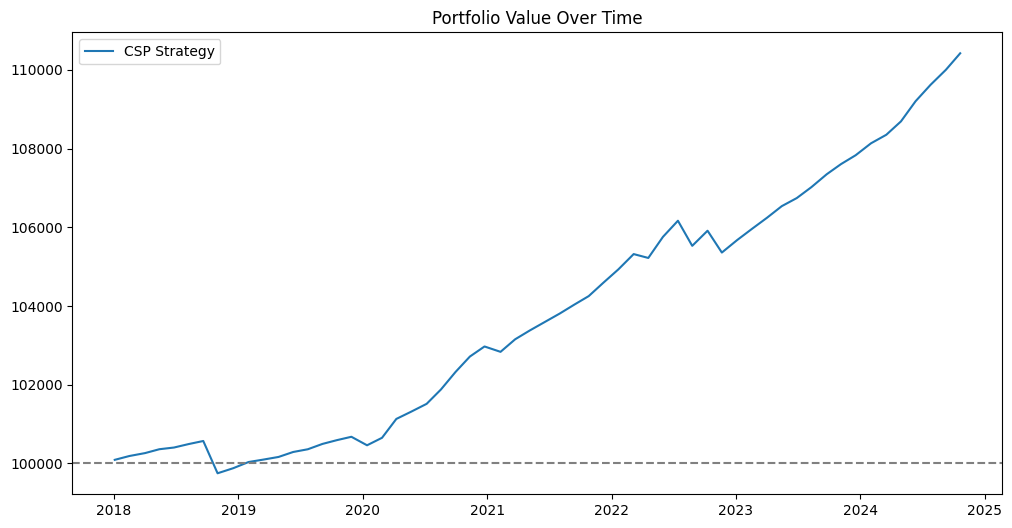

In [ ]:
plt.figure(figsize = (12,6))
plt.plot(trades_df["entry_date"], trades_df["capital"], label = "CSP Strategy")
plt.axhline(INITIAL_CAPITAL, linestyle = "--", color = "gray")
plt.legend()
plt.title("Portfolio Value Over Time")
plt.show()